In [1]:
!pip install numpyro jax

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numba import vectorize, njit
from math import gamma
import pandas as pd
import scipy.stats as sp
from scipy.integrate import quad

import seaborn as sns
colors = sns.color_palette()

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import jax.numpy as jnp
from jax import random

np.random.seed(142857)

@njit
def set_seed():
    np.random.seed(142857)
set_seed()

In [3]:
# Parameters in the two beta distributions.
F_a, F_b = 1, 1
G_a, G_b = 3, 1.2

@vectorize
def p(x, a, b):
    r = gamma(a + b) / (gamma(a) * gamma(b))
    return r * x** (a-1) * (1 - x) ** (b-1)

# The two density functions.
f = njit(lambda x: p(x, F_a, F_b))
g = njit(lambda x: p(x, G_a, G_b))

In [4]:
@njit
def simulate(a, b, T=50, N=500):
    '''
    Generate N sets of T observations of the likelihood ratio,
    return as N x T matrix.

    '''

    l_arr = np.empty((N, T))

    for i in range(N):

        for j in range(T):
            w = np.random.beta(a, b)
            l_arr[i, j] = f(w) / g(w)

    return l_arr

In [5]:
l_arr_g = simulate(G_a, G_b, N=50000)
l_seq_g = np.cumprod(l_arr_g, axis=1)

In [6]:
l_arr_f = simulate(F_a, F_b, N=50000)
l_seq_f = np.cumprod(l_arr_f, axis=1)

In [7]:
@njit
def draw_lottery(p, N):
    "Draw from the compound lottery directly."

    draws = []
    for i in range(0, N):
        if np.random.rand()<=p:
            draws.append(np.random.beta(F_a, F_b))
        else:
            draws.append(np.random.beta(G_a, G_b))

    return np.array(draws)

def draw_lottery_MC(p, N):
    "Draw from the compound lottery using the Monte Carlo trick."

    xs = np.linspace(1e-8,1-(1e-8),10000)
    CDF = p*sp.beta.cdf(xs, F_a, F_b) + (1-p)*sp.beta.cdf(xs, G_a, G_b)

    Us = np.random.rand(N)
    draws = xs[np.searchsorted(CDF[:-1], Us)]
    return draws

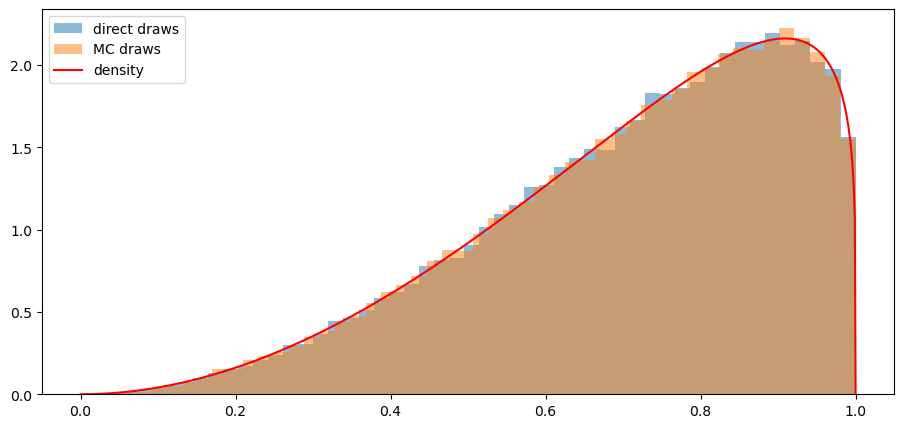

In [8]:
# verify
N = 100000
α = 0.0

sample1 = draw_lottery(α, N)
sample2 = draw_lottery_MC(α, N)

# plot draws and density function
plt.hist(sample1, 50, density=True, alpha=0.5, label='direct draws')
plt.hist(sample2, 50, density=True, alpha=0.5, label='MC draws')

xs = np.linspace(0,1,1000)
plt.plot(xs, α*f(xs)+(1-α)*g(xs), color='red', label='density')

plt.legend()
plt.show()

In [9]:
# %%timeit    # compare speed
# sample1 = draw_lottery(α, N=int(1e6))

In [10]:
# %%timeit
# sample2 = draw_lottery_MC(α, N=int(1e6))

In [11]:
@njit
def update(π, l):
    "Update π using likelihood l"

    # Update belief
    π = π * l / (π * l + 1 - π)

    return π

In [12]:
def simulate_mixed(α, T=50, N=500):
    """
    Generate N sets of T observations of the likelihood ratio,
    return as N x T matrix, when the true density is mixed h;α
    """

    w_s = draw_lottery(α, N*T).reshape(N, T)
    l_arr = f(w_s) / g(w_s)

    return l_arr

def plot_π_seq(α, π1=0.2, π2=0.8, T=200):
    """
    Compute and plot π_seq and the log likelihood ratio process
    when the mixed distribution governs the data.
    """

    l_arr_mixed = simulate_mixed(α, T=T, N=50)
    l_seq_mixed = np.cumprod(l_arr_mixed, axis=1)

    T = l_arr_mixed.shape[1]
    π_seq_mixed = np.empty((2, T+1))
    π_seq_mixed[:, 0] = π1, π2

    for t in range(T):
        for i in range(2):
            π_seq_mixed[i, t+1] = update(π_seq_mixed[i, t], l_arr_mixed[0, t])

    # plot
    fig, ax1 = plt.subplots()
    for i in range(2):
        ax1.plot(range(T+1), π_seq_mixed[i, :], label=f"$\pi_0$={π_seq_mixed[i, 0]}")

    ax1.plot(np.nan, np.nan,  '--', color='b', label='Log likelihood ratio process')
    ax1.set_ylabel("$\pi_t$")
    ax1.set_xlabel("t")
    ax1.legend()
    ax1.set_title("when $\\alpha G + (1-\\alpha)$ F governs data")

    ax2 = ax1.twinx()
    ax2.plot(range(1, T+1), np.log(l_seq_mixed[0, :]), '--', color='b')
    ax2.set_ylabel("$log(L(w^{t}))$")

    plt.show()

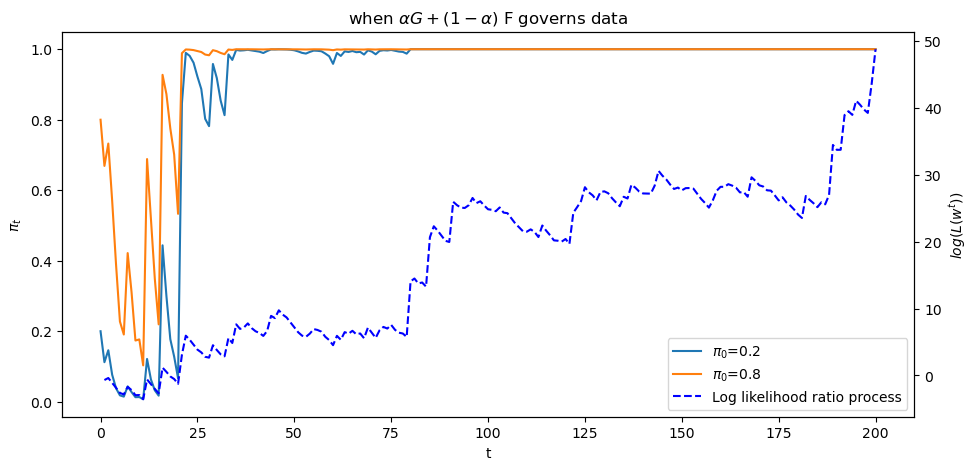

In [13]:
plot_π_seq(α = 0.6)

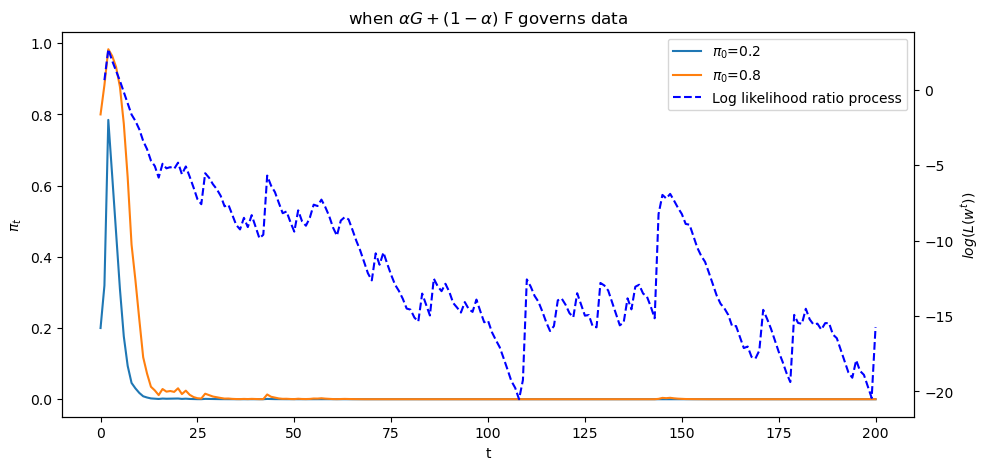

In [14]:
plot_π_seq(α = 0.2)

In [15]:
@vectorize
def KL_g(α):
    "Compute the KL divergence between g and h."
    err = 1e-8                          # to avoid 0 at end points
    ws = np.linspace(err, 1-err, 10000)
    gs, fs = g(ws), f(ws)
    hs = α*fs + (1-α)*gs
    return np.sum(np.log(gs/hs)*hs)/10000

@vectorize
def KL_f(α):
    "Compute the KL divergence between f and h."
    err = 1e-8                          # to avoid 0 at end points
    ws = np.linspace(err, 1-err, 10000)
    gs, fs = g(ws), f(ws)
    hs = α*fs + (1-α)*gs
    return np.sum(np.log(fs/hs)*hs)/10000


# compute KL using quad in Scipy
def KL_g_quad(α):
    "Compute the KL divergence between g and h using scipy.integrate."
    h = lambda x: α*f(x) + (1-α)*g(x)
    return quad(lambda x: np.log(g(x)/h(x))*h(x), 0, 1)[0]

def KL_f_quad(α):
    "Compute the KL divergence between f and h using scipy.integrate."
    h = lambda x: α*f(x) + (1-α)*g(x)
    return quad(lambda x: np.log(f(x)/h(x))*h(x), 0, 1)[0]

# vectorize
KL_g_quad_v = np.vectorize(KL_g_quad)
KL_f_quad_v = np.vectorize(KL_f_quad)


# Let us find the limit point
def π_lim(α, T=5000, π_0=0.4):
    "Find limit of π sequence."
    π_seq = np.zeros(T+1)
    π_seq[0] = π_0
    l_arr = simulate_mixed(α, T, N=1)[0]

    for t in range(T):
        π_seq[t+1] = update(π_seq[t], l_arr[t])
    return π_seq[-1]

π_lim_v = np.vectorize(π_lim)

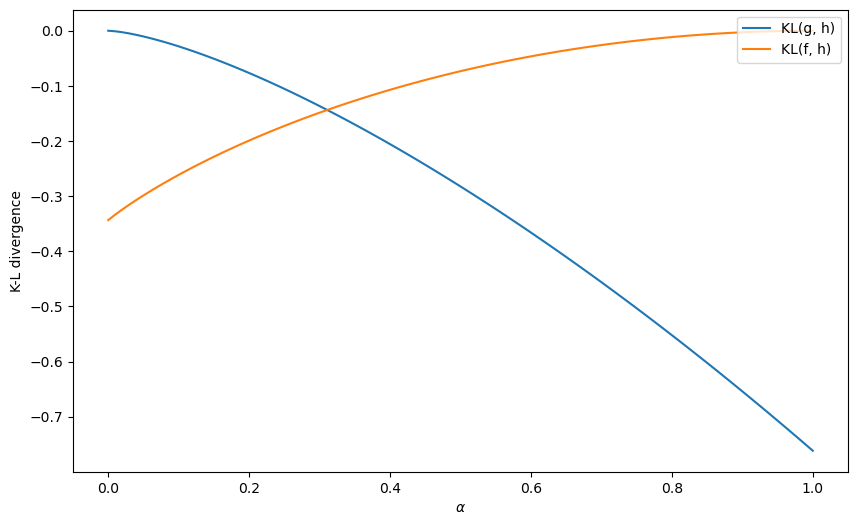

In [16]:
α_arr = np.linspace(0, 1, 100)
KL_g_arr = KL_g(α_arr)
KL_f_arr = KL_f(α_arr)

fig, ax = plt.subplots(1, figsize=[10, 6])

ax.plot(α_arr, KL_g_arr, label='KL(g, h)')
ax.plot(α_arr, KL_f_arr, label='KL(f, h)')
ax.set_ylabel('K-L divergence')
ax.set_xlabel(r'$\alpha$')

ax.legend(loc='upper right')
plt.show()

In [17]:
# # using Scipy to compute KL divergence

# α_arr = np.linspace(0, 1, 100)
# KL_g_arr = KL_g_quad_v(α_arr)
# KL_f_arr = KL_f_quad_v(α_arr)

# fig, ax = plt.subplots(1, figsize=[10, 6])

# ax.plot(α_arr, KL_g_arr, label='KL(g, h)')
# ax.plot(α_arr, KL_f_arr, label='KL(f, h)')
# ax.set_ylabel('K-L divergence')

# ax.legend(loc='upper right')
# plt.show()

In [18]:
# where KL_f = KL_g
α_arr[np.argmin(np.abs(KL_g_arr-KL_f_arr))]

0.31313131313131315

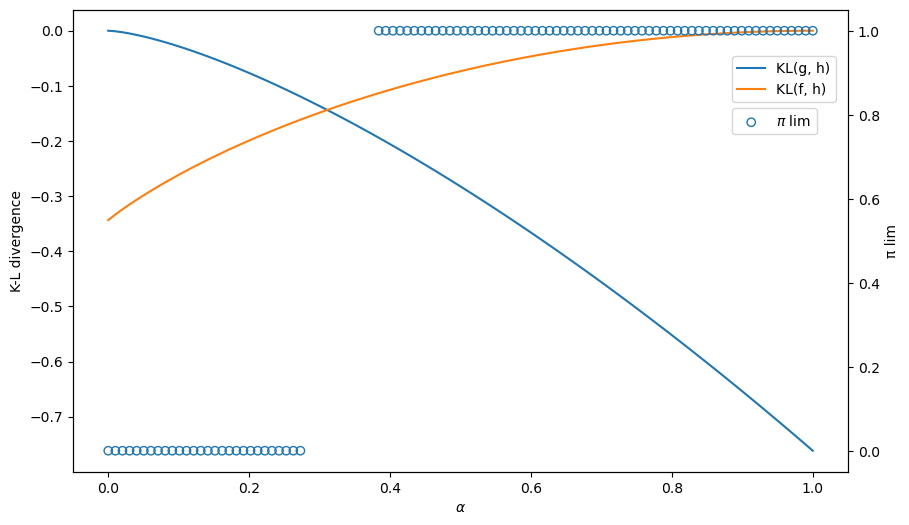

In [19]:
α_arr_x = α_arr[(α_arr<0.28)|(α_arr>0.38)]
π_lim_arr = π_lim_v(α_arr_x)

# plot
fig, ax = plt.subplots(1, figsize=[10, 6])

ax.plot(α_arr, KL_g_arr, label='KL(g, h)')
ax.plot(α_arr, KL_f_arr, label='KL(f, h)')
ax.set_ylabel('K-L divergence')
ax.set_xlabel(r'$\alpha$')

# plot KL
ax2 = ax.twinx()
# plot limit point
ax2.scatter(α_arr_x, π_lim_arr, facecolors='none', edgecolors='tab:blue', label='$\pi$ lim')
ax2.set_ylabel('π lim')

ax.legend(loc=[0.85, 0.8])
ax2.legend(loc=[0.85, 0.73])
plt.show()

In [20]:
α = 0.8

# simulate data with true α
data = draw_lottery(α, 1000)
sizes = [5, 20, 50, 200, 1000, 25000]

def model(w):
    α = numpyro.sample('α', dist.Uniform(low=0.0, high=1.0))

    y_samp = numpyro.sample('w',
        dist.Mixture(dist.Categorical(jnp.array([α, 1-α])), [dist.Beta(F_a, F_b), dist.Beta(G_a, G_b)]), obs=w)

def MCMC_run(ws):
    "Compute posterior using MCMC with observed ws"

    kernal = NUTS(model)
    mcmc = MCMC(kernal, num_samples=5000, num_warmup=1000, progress_bar=False)

    mcmc.run(rng_key=random.PRNGKey(142857), w=jnp.array(ws))
    sample = mcmc.get_samples()
    return sample['α']

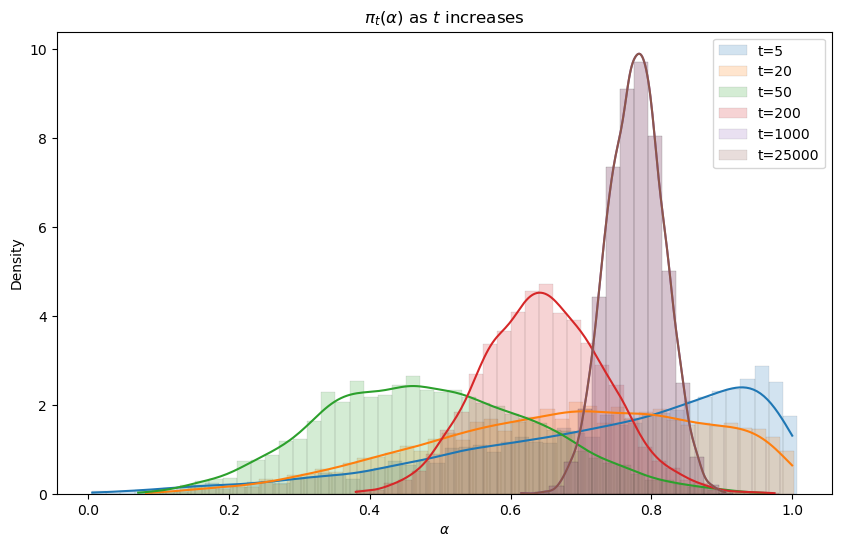

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(sizes)):
    sample = MCMC_run(data[:sizes[i]])
    sns.histplot(
        data=sample, kde=True, stat='density', alpha=0.2, ax=ax,
        color=colors[i], binwidth=0.02, linewidth=0.05, label=f't={sizes[i]}'
    )
ax.set_title('$\pi_t(\\alpha)$ as $t$ increases')
ax.legend()
ax.set_xlabel('$\\alpha$')
plt.show()